In [64]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags_array, csc_array, eye_array
import scipy.sparse.linalg as sla
import pymrm as mrm
from pymrm import construct_grad, construct_div, newton, non_uniform_grid, numjac_local, clip_approach

In [65]:
class ParticleModel:
    def __init__(self):
        self.reaction_order= 1.0
        self.D = 1.0
        self.R = 1.0
        self.N = 30
        self.bc = {'a':[1,0],'b':[0,1], 'd':[0,1]}
        self.k = 0.0
        self.dt = np.inf
        #self.r_f = np.linspace(0,self.R,self.N+1)
        dr_large = 0.1*self.R
        self.r_f = non_uniform_grid(0, self.R, self.N+1, dr_large, 0.75)
        self.r_c = 0.5*(self.r_f[0:-1]+self.r_f[1:])
        self.init_field(1)
        self.init_Jac()
        self.freq_out = 10
        self.c_small = 1e-6
    
    def init_field(self, c0=0.0):
        self.c = np.full((self.N,1),c0, dtype='float')
    
    def init_Jac(self):
        Grad, grad_bc = construct_grad(self.c.shape, self.r_f, self.r_c, self.bc)
        self.Div = construct_div(self.c.shape, self.r_f, nu=2)        
        self.Flux = -self.D * Grad
        self.flux_bc = -self.D * grad_bc
        Jac_accum = (1.0/self.dt)*eye_array(self.N,format='csc')
        self.g_const = self.Div @ self.flux_bc
        self.Jac_const = Jac_accum + self.Div@self.Flux
    
    def set_k(self, k):
        self.k = k
        
    def reaction(self, c):
        r = -self.k * c * np.power(np.abs(c) + self.c_small, self.reaction_order-1.0)
#        r = -self.k * c
        return r
    
    def construct_Jac(self, c, c_old):
        g_react, Jac_react = numjac_local(self.reaction, c, axis=1)
        g = self.g_const + self.Jac_const @ c.reshape((-1,1)) - c_old.reshape((-1,1))/self.dt - g_react
        Jac = self.Jac_const - Jac_react
        return g,Jac

    def get_apparent_reaction_rate(self):
        return -3.0/self.R*(self.Flux[[-1],:] @ self.c + self.flux_bc[[-1]])[[0]]
             
    def solve(self, num_timesteps):
        Jac = self.Jac_const
        for i in range(num_timesteps):
            c_old = self.c.copy()
            result = newton(lambda c: self.construct_Jac(c, c_old), c_old, maxfev=5, callback = clip_approach)
            self.c = result.x
            #if (i % self.freq_out == 0):
            #    plt.plot(self.r_c,self.c,'-o')
        #plt.show()

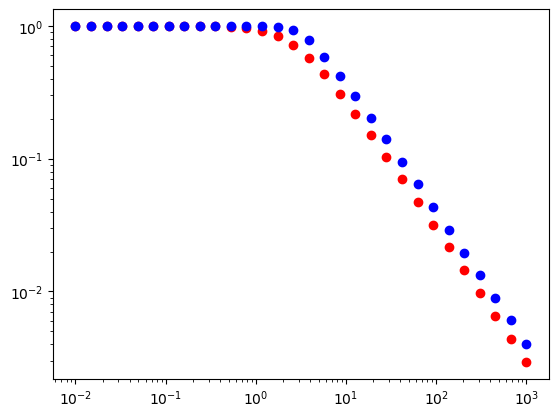

In [66]:
mrm_problem = ParticleModel()
phis = np.logspace(-2,3,30)

mrm_problem.reaction_order = 1.0
for phi in phis:
    k = phi**2*mrm_problem.D/mrm_problem.R
    mrm_problem.set_k(k)
    mrm_problem.solve(1)
    eta = mrm_problem.get_apparent_reaction_rate()/k
    plt.loglog(phi, eta, marker = 'o', linestyle = '', color = 'red')

mrm_problem.reaction_order = 0.1
mrm_problem.init_field(1.0)
for phi in phis:
    k = phi**2*mrm_problem.D/mrm_problem.R
    mrm_problem.set_k(k)
    mrm_problem.solve(1)
    eta = mrm_problem.get_apparent_reaction_rate()/k
    plt.loglog(phi, eta, marker = 'o', linestyle = '', color = 'blue')



#plt.loglog(phis, 3*(phis/np.tanh(phis)-1)/(phis*phis), color = 'blue', label = r'$\eta = 3(\phi \coth(\phi)-1)/\phi^2$')
#plt.xlabel(r'Thiele modulus, $\phi$')
#plt.ylabel(r'effectiveness factor, $\eta$')
#plt.show()